In [8]:
%load_ext autoreload
%autoreload 2

import os

os.chdir(globals()["_dh"][0])
os.chdir("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import models_mae_hetero
import torch

from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.tensorboard import SummaryWriter

from gaussian_noise import AddGaussianNoise
from dataset_classes.pretrain_csi_5g import CSI5G
from dataset_classes.pretrain_csi_wifi import CSIWiFi
from dataset_classes.spectrogram_images import SpectrogramImages

from torch.utils.data import DataLoader, RandomSampler
import torch.nn.functional as F

import util.misc as misc
from util.misc import NativeScalerWithGradNormCount as NativeScaler

import timm.optim.optim_factory as optim_factory

import models_mae_hetero
from engine_pretrain_hetero import train_one_epoch

from tqdm import tqdm

import torch_pruning as tp

import timm
import copy

import numpy as np

import matplotlib.pyplot as plt

from engine_pretrain_hetero import RoundRobinLoader


In [3]:
model = 'mae_vit_small_patch16'
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# define the model
model = models_mae_hetero.__dict__[model](norm_pix_loss=False, in_chans=[1, 3, 4])
model.to(device)

model_without_ddp = model
print("Model = %s" % str(model_without_ddp))

Model = MaskedAutoencoderViT(
  (patch_embed): ModuleList(
    (0): PatchEmbed(
      (proj): Conv2d(1, 512, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (1): PatchEmbed(
      (proj): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (2): PatchEmbed(
      (proj): Conv2d(4, 512, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
     

In [4]:
model = torch.load('/home/ict317-3/Mohammad/Tiny-WFMs/output_dir/best_model.pth', weights_only=False)

In [5]:
model

CEViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(2, 512, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (drop2): Dropout(p=0.

In [4]:
augmentation = True

data_path = ['/home/ict317-3/Mohammad/Tiny-WFMs/pretraining_datasets/spectrogram_dataset',
             '/home/ict317-3/Mohammad/Tiny-WFMs/pretraining_datasets/spectrogram_iqengine_dataset',
             '/home/ict317-3/Mohammad/Tiny-WFMs/pretraining_datasets/5G_CFR',
             '/home/ict317-3/Mohammad/Tiny-WFMs/pretraining_datasets/NTU-Fi-HumanID']

log_dir = './output_dir'

transform_train = transforms.Compose([
        transforms.functional.pil_to_tensor,
        transforms.Lambda(lambda x: 10 * torch.log10(x + 1e-12)),
        transforms.Lambda(lambda x: (x + 120) / (-0.5 + 120)),
        transforms.Resize((224, 224), antialias=True,
                          interpolation=InterpolationMode.BICUBIC),  # Resize
        transforms.Normalize(mean=[0.451], std=[0.043])  # Normalize
    ])

dataset_train_one = SpectrogramImages(data_path[:-2], transform=transform_train)

augment_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    AddGaussianNoise(mean=0.0, std=0.05)]
)

if augmentation:
        dataset_train_two = CSI5G(data_path[-2], augment_transforms=augment_transforms)
        dataset_train_three = CSIWiFi(data_path[-1], augment_transforms=augment_transforms)
else:
    dataset_trainlog_dir_two = CSI5G(data_path[-2])
    dataset_train_three = CSIWiFi(data_path[-1])

print(dataset_train_one, dataset_train_two, dataset_train_three)

sampler_train_one = RandomSampler(dataset_train_one)
sampler_train_two = RandomSampler(dataset_train_two)
sampler_train_three = RandomSampler(dataset_train_three)

os.makedirs(log_dir, exist_ok=True)
log_writer = SummaryWriter(log_dir=log_dir)



<dataset_classes.spectrogram_images.SpectrogramImages object at 0x7988679ee990> <dataset_classes.pretrain_csi_5g.CSI5G object at 0x798867952bd0> <dataset_classes.pretrain_csi_wifi.CSIWiFi object at 0x79885038efd0>


In [5]:
batch_size = 16
num_workers = 10
pin_mem = True
csi_subsampling = False

data_loader_train_one = DataLoader(
        dataset_train_one, sampler=sampler_train_one,
        batch_size= batch_size,
        num_workers= num_workers,
        pin_memory= pin_mem,
        drop_last=True)

if  csi_subsampling:
    data_loader_train_two = DataLoader(
        dataset_train_two, sampler=sampler_train_two,
        batch_size= batch_size // 2,
        num_workers= num_workers,
        pin_memory= pin_mem,
        drop_last=True)

    data_loader_train_three = DataLoader(
        dataset_train_three, sampler=sampler_train_three,
        batch_size= batch_size // 2,
        num_workers= num_workers,
        pin_memory= pin_mem,
        drop_last=True)
else:
    data_loader_train_two = DataLoader(
        dataset_train_two, sampler=sampler_train_two,
        batch_size= batch_size,
        num_workers= num_workers,
        pin_memory= pin_mem,
        drop_last=True)

    data_loader_train_three = DataLoader(
        dataset_train_three, sampler=sampler_train_three,
        batch_size= batch_size,
        num_workers= num_workers,
        pin_memory= pin_mem,
        drop_last=True)


In [6]:
accum_iter = 1
lr = None
blr = 1e-3


eff_batch_size =  batch_size *accum_iter
    
if lr is None:  # only base_lr is specified
     lr = blr * eff_batch_size / 256

print("base lr: %.2e" % ( lr * 256 / eff_batch_size))
print("actual lr: %.2e" %  lr)

print("accumulate grad iterations: %d" %accum_iter)
print("effective batch size: %d" % eff_batch_size)


base lr: 1.00e-03
actual lr: 6.25e-05
accumulate grad iterations: 1
effective batch size: 16


In [7]:
weight_decay = 0.05

# following timm: set wd as 0 for bias and norm layers
param_groups = optim_factory.param_groups_weight_decay(model_without_ddp, weight_decay)
optimizer = torch.optim.AdamW(param_groups, lr=lr, betas=(0.9, 0.95))
print(optimizer)
loss_scaler = NativeScaler()

ckpt_path = '/home/ict317-3/Mohammad/Tiny-WFMs/checkpoints/pretrained_all_data.pth'
pretrained = torch.load(ckpt_path, map_location=device, weights_only=False)['model']
model.load_state_dict(pretrained, strict=False)


AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 6.25e-05
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 6.25e-05
    maximize: False
    weight_decay: 0.05
)


/home/ict317-3/Mohammad/Tiny-WFMs/util/misc.py:254: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler()


<All keys matched successfully>

In [10]:
# def compute_baseline_performance(model, mask_ratio, kernel_size, dataset_id, device):

#     accuracy = 0
#     total_loss = 0

#     model.eval()

#     model = model.to(device)
        
#     data = {
#         1: (dataset_train_one,   data_loader_train_one),
#         2: (dataset_train_two,   data_loader_train_two),
#         3: (dataset_train_three, data_loader_train_three),
#     }
#     assert dataset_id in data, f"dataset_id must be 1, 2, or 3, got {dataset_id}"


#     with torch.no_grad():
       
#         for k, (images, _) in enumerate(tqdm(data[dataset_id][1], desc="Batches", leave=False)):
#             images = images.to(device)
#             loss, reconstructed, mask = model(images, mask_ratio=mask_ratio / 100)
#             images = torch.einsum('nchw->nhwc', images)
#             reconstructed = torch.einsum('nchw->nhwc', model.unpatchify(reconstructed))
#             mask = model.unpatchify(mask.unsqueeze(-1).repeat(1, 1, 16 ** 2 * 1))
#             mask = torch.einsum('nchw->nhwc', mask)
#             reconstructed = (1 - mask) * images + mask * reconstructed

#             pooled_images = F.avg_pool2d(images.permute(0, 3, 1, 2), kernel_size=kernel_size, stride=kernel_size)
#             pooled_reconstructed = F.avg_pool2d(reconstructed.permute(0, 3, 1, 2), kernel_size=kernel_size, stride=kernel_size)
#             mu, std = torch.mean(pooled_images, dim=(1, 2, 3)), torch.std(pooled_images, dim=(1, 2, 3))
#             threshold = mu + 0.5 * std
#             threshold = threshold.view(-1, 1, 1, 1).repeat((1, 1, pooled_images.shape[2], pooled_images.shape[3]))
#             pooled_images = pooled_images > threshold
#             pooled_reconstructed = pooled_reconstructed > threshold

#             accuracy += (pooled_images == pooled_reconstructed).sum().item()
#             total_loss += loss.item() 

#     accuracy /= (len(data[dataset_id][0]) * (224 // kernel_size) ** 2)
#     avg_loss = total_loss / len(data[dataset_id][1])

#     print(accuracy)
#     return avg_loss

In [8]:
def compute_loss_per_loader(model, device, data_loader, mask_ratio=75, kernel_size=3):
    model.eval()
    model.to(device)

    # map id -> (dataset, loader)
    # data = {
    #     1: data_loader_train_one,
    #     2: data_loader_train_two,
    #     3: data_loader_train_three,
    # }
    # assert dataset_id in data, f"dataset_id must be 1, 2, or 3, got {dataset_id}"

    # loader = data[dataset_id]

    total_equal = 0
    total_cells_seen = 0
    total_loss = 0.0

    # Try to infer patch size and channels for robust unpatchify of the mask
    # Fallback to 16 and 1 if the model doesn't expose it
    try:
        p = getattr(model, "patch_embed").patch_size[0]  # e.g., 16
    except Exception:
        p = 16
    # We'll infer channels per batch from the images

    with torch.no_grad():
        for images, _ in tqdm(data_loader, desc="Batches", leave=False):
            images = images.to(device)  # NCHW expected here from your dataset pipeline

            # forward
            loss, reconstructed, mask = model(images, mask_ratio=mask_ratio / 100.0)

            # Unpatchify outputs (assumes MAE-like shapes)
            # reconstructed: (N, L, p*p*C), mask: (N, L)
            # Infer channels from the reconstructed payload if possible
            # C = (reconstructed.shape[-1] // (p * p)) if reconstructed.ndim == 3 else images.shape[1]
            if reconstructed.ndim == 3:
                C = reconstructed.shape[-1] // (p * p)
            else:
                C = images.shape[1]

            reconstructed = model.unpatchify(reconstructed)  # -> (N, C, H, W)
            # Broadcast mask from (N, L) to (N, p*p*C, L) before unpatchify
            mask_expanded = mask.unsqueeze(-1).repeat(1, 1, p * p * C)
            mask_img = model.unpatchify(mask_expanded)  # (N, C, H, W)

            # Blend original and reconstructed only on masked regions
            blended = (1 - mask_img) * images + mask_img * reconstructed  # all NCHW

            # Pool down to grids
            pooled_images = F.avg_pool2d(images, kernel_size=kernel_size, stride=kernel_size)
            pooled_blended = F.avg_pool2d(blended, kernel_size=kernel_size, stride=kernel_size)

            # Per-sample thresholds from original pooled images
            # mean/std over (C,H,W)
            mu = pooled_images.mean(dim=(1, 2, 3))
            std = pooled_images.std(dim=(1, 2, 3), unbiased=False)  # avoid NaNs when only 1 cell
            threshold = (mu + 0.5 * std).view(-1, 1, 1, 1)

            # Binarize
            bin_images = pooled_images > threshold
            bin_blended = pooled_blended > threshold

            # Count equal cells
            equal_cells = (bin_images == bin_blended).sum().item()
            total_equal += equal_cells

            # Track how many cells we actually processed
            n, c, h, w = bin_images.shape
            total_cells_seen += n * c * h * w

            # Accumulate batch loss
            total_loss += float(loss.item())

    # Safe aggregations
    accuracy = total_equal / max(1, total_cells_seen)
    avg_loss = total_loss / max(1, len(data_loader))

    return avg_loss, accuracy


In [15]:
# mask_ratio = 75
# kernel_size = 3
# dataset_id = 3


# loss = compute_loss_per_loader(model, data_loader_train_one, device)
# print(loss)

In [9]:
def compute_baseline_performance(model, device, data_loaders):

    overall_loss = sum(compute_loss_per_loader(model, device, loader)[0] for loader in data_loaders) / len(data_loaders)
    
    return overall_loss

In [17]:
# def forward_encoder_new(self, x, mask_ratio):
#         # embed patches
#         x = self.patch_embed(x)

#         # add pos embed w/o cls token
#         x = x + self.pos_embed[:, 1:, :]

#         # masking: length -> length * mask_ratio
#         x, mask, ids_restore = self.random_masking(x, mask_ratio)

#         # append cls token
#         cls_token = self.cls_token + self.pos_embed[:, :1, :]
#         cls_tokens = cls_token.expand(x.shape[0], -1, -1)
#         x = torch.cat((cls_tokens, x), dim=1)

#         # apply Transformer blocks
#         for blk in self.blocks:
#             x = blk(x)
#         x = self.norm(x)

#         return x, mask, ids_restore


# def forward_decoder_new(self, x, ids_restore):
#         # embed tokens
#         x = self.decoder_embed(x)

#         # append mask tokens to sequence
#         mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
#         x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
#         x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
#         x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

#         # add pos embed
#         x = x + self.decoder_pos_embed

#         # apply Transformer blocks
#         for blk in self.decoder_blocks:
#             x = blk(x)
#         x = self.decoder_norm(x)

#         # predictor projection
#         x = self.decoder_pred(x)

#         # remove cls token
#         x = x[:, 1:, :]

#         return x

# def forward_new(self, imgs, mask_ratio=0.75):
#     latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)  # <- renamed
#     pred = self.forward_decoder(latent, ids_restore)                    # <- renamed
#     loss = self.forward_loss(imgs, pred, mask)
#     return loss, pred, mask

# import types

# model.forward_encoder = types.MethodType(forward_encoder_new, model)
# model.forward_decoder = types.MethodType(forward_decoder_new, model)
# model.forward          = types.MethodType(forward_new, model)

In [ ]:
# data_loaders = [data_loader_train_one, data_loader_train_two, data_loader_train_three]

# loss = compute_baseline_performance(model, 'cuda', data_loaders)

# loss

In [10]:
def get_blocks(model):
    ignored_blocks = []
    model_blocks = []
    num_heads = {}
    bottleneck = False

    for m in model.modules():
        if isinstance(m, timm.models.vision_transformer.Attention):
            num_heads[m.qkv] = m.num_heads
        if bottleneck and isinstance(m, timm.models.vision_transformer.Mlp):
            ignored_blocks.append(m.fc2)

    for name, layer in model.named_children():
        if name != 'blocks':
            if len(list(layer.children())) > 0:
                ignored_blocks.extend(layer.children())
            else:
                ignored_blocks.append(layer)
        else:
            if len(list(layer.children())) > 0:
                model_blocks.extend(layer.children())
            else:
                model_blocks.append(layer)

    return model_blocks, ignored_blocks, num_heads


In [11]:
def selective_block_pruning(trained_model, device, pruning_ratios, prune_method, data_loaders, mask_ratio):
    model = copy.deepcopy(trained_model)
    for param in model.parameters():
        param.requires_grad = True

    model_blocks, ignored_blocks, num_heads = get_blocks(model)
    model.to(device)

    pruning_info = {
        i: {"block": model_blocks[i], "pruning_ratio": ratio}
        for i, ratio in enumerate(pruning_ratios)
    }

    if prune_method == 'channel_pruning_Taylor_importance':
        imp = tp.importance.GroupTaylorImportance()

        combined_iter = RoundRobinLoader(data_loaders)

        if isinstance(imp, tp.importance.GroupTaylorImportance):
            model.zero_grad()
            model.train(True)

            print("Accumulating gradients for pruning...")
            for data_iter_step, (key, samples, labels) in enumerate(combined_iter):
                samples, labels = samples.to(device), labels.to(device)
                if data_iter_step >= 60: # 20 samples of each dataloader for now
                    break
                loss, _, _ = model(samples, mask_ratio=mask_ratio / 100)
                loss.backward()

        original_macs, original_nparams = tp.utils.count_ops_and_params(model, samples)

        for i, info in pruning_info.items():
            pruning_ratio = info["pruning_ratio"]
            if pruning_ratio == 0:
                continue

            ignored_layers_block = [pruning_info[j]["block"] for j in range(len(pruning_info)) if j != i]
            combined_ignored_layers = ignored_blocks + ignored_layers_block
            # print('combined_ignored_layers:   ', combined_ignored_layers)
            
            count = 0
            while True:
                pruner = tp.pruner.MetaPruner(
                    model,
                    example_inputs=samples,
                    importance=imp,
                    pruning_ratio=pruning_ratio,
                    ignored_layers=combined_ignored_layers,
                    num_heads=num_heads,
                    prune_num_heads=False,
                    prune_head_dims=True
                )
                for g in pruner.step(interactive=True):
                    g.prune()

                # print(f'A pruning process has been performed here with a {pruning_ratio} pruning ratio ...  ')
                
                for m in model.modules():
                    if isinstance(m, timm.models.vision_transformer.Attention):
                        m.num_heads = pruner.num_heads[m.qkv]
                        m.head_dim = m.qkv.out_features // (3 * m.num_heads)

                macs, nparams = tp.utils.count_ops_and_params(model, samples)

                if original_nparams - nparams == 0:
                    count += 1
                    if count == 1:
                        pruning_ratio = 0.5
                    else:
                        break

                original_nparams = nparams

        del samples, labels
        torch.cuda.empty_cache()

    return model, macs, nparams

In [12]:
def perplexity_analysis_with_contributions(original_model, device, metric, measure_performance, data_loaders, mask_ratio=75):
    model_blocks, _, _ = get_blocks(original_model)
    blocks_number = len(model_blocks)

    total_block_performance = [0.0 for _ in range(blocks_number)]
    params_reduction = []
    macs_reduction = []

    original_model.to(device)

    print(f"Computing baseline {metric} without block replacement...")
    baseline_performance = measure_performance(original_model, device, data_loaders)
    print(f"Baseline {metric}: {baseline_performance}")

    example_inputs = next(iter(data_loaders[0]))[0].to(device)
    original_macs, original_nparams = tp.utils.count_ops_and_params(original_model, example_inputs)

    for block_idx in range(blocks_number):
        print(f"Replacing block {block_idx}")
        pruning_ratios = (np.eye(blocks_number) * 0.85)[block_idx]
        pruned_model, macs, nparams = selective_block_pruning(
            original_model, device, pruning_ratios, 'channel_pruning_Taylor_importance', data_loaders, mask_ratio
        )

        params_reduction.append((original_nparams - nparams)/original_nparams * 100)
        macs_reduction.append((original_macs - macs) / original_macs * 100)

        pruned_model.to(device)
        block_performance = measure_performance(pruned_model, device, data_loaders)
        total_block_performance[block_idx] = block_performance
        print(f'The {metric} after pruning this block is: {block_performance}')

    total_degradation_in_performance = 0.0
    block_degradation = []
    total_params_reduction = 0.0
    total_macs_reduction = 0.0

    for block_idx in range(blocks_number):
        degradation = np.abs(total_block_performance[block_idx] - baseline_performance)
        print(f"Degradation in {metric} is: {degradation}")
        block_degradation.append(degradation)
        total_degradation_in_performance += degradation
        total_params_reduction += params_reduction[block_idx]
        total_macs_reduction += macs_reduction[block_idx]

    relative_contributions = []
    weighted_importance_scores = []

    print(f"\nRelative contribution of each block to total {metric} degradation and parameter reduction:")
    for block_idx in range(blocks_number):
        rel_perf = (block_degradation[block_idx] / total_degradation_in_performance) * 100
        rel_params = 100 - params_reduction[block_idx]
        rel_macs = 100 - macs_reduction[block_idx]

        weighted_importance = (0.7 * rel_perf) + (0.2 * rel_params) + (0.1 * rel_macs)
        print(f'Block {block_idx} contributes {rel_perf:.2f}% to the total degradation in {metric} and reduces {params_reduction[block_idx]:.2f}% of parameters.')
        print(f'Weighted importance score for Block {block_idx}: {weighted_importance:.2f}')

        relative_contributions.append(rel_perf)
        weighted_importance_scores.append(weighted_importance)

    return weighted_importance_scores

## Performing the compression

In [13]:
def forward(self, x):
    """https://github.com/huggingface/pytorch-image-models/blob/054c763fcaa7d241564439ae05fbe919ed85e614/timm/models/vision_transformer.py#L79"""
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
    q, k, v = qkv.unbind(0)
    q, k = self.q_norm(q), self.k_norm(k)

    if self.fused_attn:
        x = F.scaled_dot_product_attention(
            q, k, v,
            dropout_p=self.attn_drop.p,
        )
    else:
        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = attn @ v

    x = x.transpose(1, 2).reshape(B, N, -1) # original implementation: x = x.transpose(1, 2).reshape(B, N, C)
    x = self.proj(x)
    x = self.proj_drop(x)
    return x

# Override attention forward
for m in model.modules():
    if isinstance(m, timm.models.vision_transformer.Attention):
        m.forward = forward.__get__(m, timm.models.vision_transformer.Attention)
        
# Analyze contributions
# relative_contribution = perplexity_analysis_with_contributions(
#     model,
#     device=device,
#     metric='loss',
#     measure_performance=compute_baseline_performance,
#     data_loaders=[data_loader_train_one, data_loader_train_two, data_loader_train_three]
# )

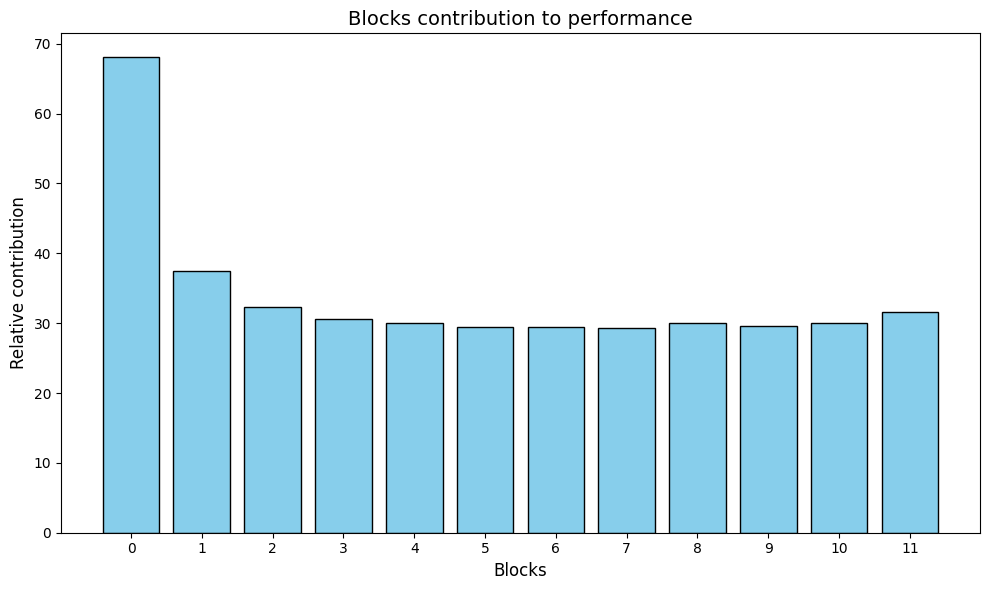

In [14]:
relative_contribution = [np.float64(68.08877057598382),
 np.float64(37.40626909822759),
 np.float64(32.281119143100256),
 np.float64(30.637165097452176),
 np.float64(30.020183495139563),
 np.float64(29.474453270385183),
 np.float64(29.440264146737952),
 np.float64(29.357529826182528),
 np.float64(29.954904338606084),
 np.float64(29.66567846836903),
 np.float64(30.0643648149045),
 np.float64(31.607907928914102)]

x = np.arange(len(relative_contribution))

plt.figure(figsize=(10,6))
plt.bar(x, relative_contribution, color='skyblue', edgecolor='black')

plt.xlabel("Blocks", fontsize=12)
plt.ylabel("Relative contribution", fontsize=12)
plt.title("Blocks contribution to performance", fontsize=14)
plt.xticks(x)  # show indices as x-axis labels

plt.tight_layout()
plt.show()

In [15]:
def calculate_pruning_ratios(contributions, max_pruning_ratio=0.9, k=5):
    """
    Calculate pruning ratios based on intense nonlinear scaling (exponential decay) of the relative contributions.

    Parameters:
    - contributions (list): List of relative contributions (in percentages) of each block to total loss increase.
    - max_pruning_ratio (float): Maximum pruning ratio to be assigned to the least important layer. Default is 0.9.
    - k (int): Factor controlling the intensity of the scaling (larger k makes the ratio more intense).

    Returns:
    - pruning_ratios (list): List of pruning ratios for each block.
    """
    # Normalize the contributions to get values between 0 and 1
    total_contribution = sum(contributions)
    normalized_contributions = [contribution / total_contribution for contribution in contributions]

    # Apply exponential decay to magnify the effect for less important blocks
    pruning_factors = [np.exp(-k * nc) for nc in normalized_contributions]

    # Normalize the pruning factors so they stay within the max pruning ratio
    max_factor = max(pruning_factors)
    normalized_factors = [pf / max_factor for pf in pruning_factors]

    # Scale by the maximum pruning ratio
    pruning_ratios = [max_pruning_ratio * nf for nf in normalized_factors]

    pruning_ratios = [round(num, 2) for num in pruning_ratios]

    return pruning_ratios

In [16]:
def prune_model(trained_model, device, pruning_ratios, prune_method, data_loaders, mask_ratio=75):
    model = copy.deepcopy(trained_model)

    for param in model.parameters():
        param.requires_grad = True

    model_blocks, ignored_blocks, num_heads = get_blocks(model)
    model.to(device)

    pruning_info = {
        i: {"block": model_blocks[i], "pruning_ratio": ratio}
        for i, ratio in enumerate(pruning_ratios)
    }

    if prune_method == 'channel_pruning_Taylor_importance':
        imp = tp.importance.GroupTaylorImportance()

        combined_iter = RoundRobinLoader(data_loaders)

        if isinstance(imp, tp.importance.GroupTaylorImportance):
            model.zero_grad()
            model.train(True)

            print("Accumulating gradients for pruning...")
            for data_iter_step, (key, samples, labels) in enumerate(combined_iter):
                samples, labels = samples.to(device), labels.to(device)
                if data_iter_step >= 60: # 20 samples of each dataloader for now
                    break
                loss, _, _ = model(samples, mask_ratio=mask_ratio / 100)
                loss.backward()

        original_macs, original_nparams = tp.utils.count_ops_and_params(model, samples)

        for i, info in pruning_info.items():
            pruning_ratio = info["pruning_ratio"]
   

            ignored_layers_block = [pruning_info[j]["block"] for j in range(len(pruning_info)) if j != i]
            combined_ignored_layers = ignored_blocks + ignored_layers_block
            # print('combined_ignored_layers:   ', combined_ignored_layers)
            
            print(f"Pruning block {i} with pruning ratio: {pruning_ratio}")

            pruner = tp.pruner.MetaPruner(
                model,
                example_inputs=samples,
                importance=imp,
                pruning_ratio=pruning_ratio,
                ignored_layers=combined_ignored_layers,
                num_heads=num_heads,
                prune_num_heads=False,
                prune_head_dims=True
            )
            for g in pruner.step(interactive=True):
                g.prune()

            # print(f'A pruning process has been performed here with a {pruning_ratio} pruning ratio ...  ')
            
            for m in model.modules():
                if isinstance(m, timm.models.vision_transformer.Attention):
                    m.num_heads = pruner.num_heads[m.qkv]
                    m.head_dim = m.qkv.out_features // (3 * m.num_heads)

            macs, nparams = tp.utils.count_ops_and_params(model, samples)

            print(f"MACs: {macs / 1e9:.2f} G, #Params: {nparams / 1e3:.2f} K")
            print(f"Parameter reduction: {((original_nparams - nparams) / original_macs * 100):.2f}%")
            print(f"MACs reduction: {((original_macs - macs) / original_macs * 100):.2f}%")
        

                
        del samples, labels
        torch.cuda.empty_cache()

    return model, macs, nparams

In [ ]:
max_pruning_ratio = 0.9 # Maximum pruning ratio (99%) 
k = 5 # Controls the intensity of the scaling

pruning_ratios = calculate_pruning_ratios(relative_contribution, max_pruning_ratio, k)

# Print the pruning ratios for each block
for i, ratio in enumerate(pruning_ratios):
    print(f"Block {i} Pruning Ratio: {ratio:.4f}")

Block 0 Pruning Ratio: 0.5000
Block 1 Pruning Ratio: 0.5400
Block 2 Pruning Ratio: 0.5500
Block 3 Pruning Ratio: 0.5500
Block 4 Pruning Ratio: 0.5500
Block 5 Pruning Ratio: 0.5500
Block 6 Pruning Ratio: 0.5500
Block 7 Pruning Ratio: 0.5500
Block 8 Pruning Ratio: 0.5500
Block 9 Pruning Ratio: 0.5500
Block 10 Pruning Ratio: 0.5500
Block 11 Pruning Ratio: 0.5500


In [25]:
data_loaders = [data_loader_train_one, data_loader_train_two, data_loader_train_three]
pruned_model, macs, nparams = prune_model(model, device, pruning_ratios, 'channel_pruning_Taylor_importance', data_loaders)

Accumulating gradients for pruning...
Pruning block 0 with pruning ratio: 0.5


/home/ict317-3/Mohammad/Tiny-WFMs/wavenv/lib/python3.11/site-packages/torch_pruning/dependency.py:699: UserWarning: Unwrapped parameters detected: ['pos_embed', 'decoder_pos_embed', 'mask_token', 'cls_token'].
 Torch-Pruning will prune the last non-singleton dimension of these parameters. If you wish to change this behavior, please provide an unwrapped_parameters argument.
  warnings.warn(warning_str)


MACs: 3.29 G, #Params: 44433.41 K
Parameter reduction: 0.05%
MACs reduction: 2.47%
Pruning block 1 with pruning ratio: 0.54
MACs: 3.20 G, #Params: 42725.48 K
Parameter reduction: 0.10%
MACs reduction: 5.14%
Pruning block 2 with pruning ratio: 0.55
MACs: 3.11 G, #Params: 40979.61 K
Parameter reduction: 0.15%
MACs reduction: 7.86%
Pruning block 3 with pruning ratio: 0.55
MACs: 3.02 G, #Params: 39233.75 K
Parameter reduction: 0.20%
MACs reduction: 10.58%
Pruning block 4 with pruning ratio: 0.55
MACs: 2.93 G, #Params: 37487.89 K
Parameter reduction: 0.25%
MACs reduction: 13.31%
Pruning block 5 with pruning ratio: 0.55
MACs: 2.84 G, #Params: 35742.03 K
Parameter reduction: 0.30%
MACs reduction: 16.03%
Pruning block 6 with pruning ratio: 0.55
MACs: 2.74 G, #Params: 33996.16 K
Parameter reduction: 0.36%
MACs reduction: 18.76%
Pruning block 7 with pruning ratio: 0.55
MACs: 2.65 G, #Params: 32250.30 K
Parameter reduction: 0.41%
MACs reduction: 21.48%
Pruning block 8 with pruning ratio: 0.55
MAC

In [36]:
images = next(iter(data_loaders[0]))[0].to(device)
model.to(device)

base_macs, base_nparams = tp.utils.count_ops_and_params(model, images)
macs, nparams = tp.utils.count_ops_and_params(pruned_model, images)

print(f"MACs: {base_macs/1e9} G -> {macs/1e9} G, #Params: {base_nparams/1e6} M -> {nparams/1e6} M")
p_ratio = ((base_nparams - nparams) / base_nparams * 100)

print(f"Overall parameter reduction: {(p_ratio):.2f}%")
print(f"Overall MACs reduction: {((base_macs - macs) / base_macs * 100):.2f}%")
            

MACs: 3.376390688 G -> 2.4201433056875 G, #Params: 46.008064 M -> 27.959995 M
Overall parameter reduction: 39.23%
Overall MACs reduction: 28.32%


In [37]:
torch.save(pruned_model, f'our_pruned_models/pruned_autoencoder/Vit_pruned_{(p_ratio):.2f}%.pth')

## Applying pruning on only the first block

In [ ]:
def count_encoder_params(model, exclude_prefixes=("decoder",), include_buffers=False, verbose=True):
    """
    Counts parameters for everything except the decoder part.
    Any top-level child whose name starts with one of `exclude_prefixes`
    (e.g., 'decoder', 'decoder_') is excluded along with all its descendants.

    Works with models whose children include:
      ['patch_embed', 'blocks', 'norm', 'decoder_embed', 'decoder_blocks', 'decoder_norm', 'decoder_pred']

    Args:
        model: nn.Module
        exclude_prefixes: tuple of prefixes to exclude at top level (default: ("decoder",))
        include_buffers: if True, also include buffers (e.g., running stats) in the total
        verbose: print a human summary

    Returns:
        dict with total, trainable, non_trainable, ratio (2 decimals)
    """
    # Collect which top-level children are considered decoder
    decoder_roots = {name for name, _ in model.named_children()
                     if any(name.startswith(pref) for pref in exclude_prefixes)}

    total = 0
    trainable = 0

    # Parameters: keep only those whose top-level token is NOT a decoder root
    for name, p in model.named_parameters():
        root = name.split('.', 1)[0]
        if root in decoder_roots or any(root.startswith(pref) for pref in exclude_prefixes):
            continue
        n = p.numel()
        total += n
        if p.requires_grad:
            trainable += n

    # Optionally add buffers (doesn't change "trainable", but affects total/non_trainable)
    if include_buffers:
        for name, b in model.named_buffers():
            root = name.split('.', 1)[0]
            if root in decoder_roots or any(root.startswith(pref) for pref in exclude_prefixes):
                continue
            total += b.numel()

    non_trainable = total - trainable
    ratio = (trainable / total) if total else float("nan")

    if verbose:
        def human(n): return f"{n:,} ({n/1e6:.2f}M)"
        print("[ENCODER ONLY]")
        print(f"Total params        : {human(total)}")
        print(f"Trainable params    : {human(trainable)}")
        print(f"Non-trainable params: {human(non_trainable)}")
        print(f"Trainable/Total     : {ratio:.2f}")

    return {
        "total": total,
        "trainable": trainable,
        "non_trainable": non_trainable,
        "ratio": float(f"{ratio:.2f}") if ratio == ratio else ratio,
    }



max_pruning_ratio = 0.9 # Maximum pruning ratio (99%) 
k = 0 # Controls the intensity of the scaling

pruning_ratios = calculate_pruning_ratios(relative_contribution, max_pruning_ratio, k)

# Print the pruning ratios for each block
for i, ratio in enumerate(pruning_ratios):
    print(f"Block {i} Pruning Ratio: {ratio:.4f}")

data_loaders = [data_loader_train_one, data_loader_train_two, data_loader_train_three]
pruned_model, macs, nparams = prune_model(model, device, pruning_ratios, 'channel_pruning_Taylor_importance', data_loaders)

encoder = copy.deepcopy(model)
encoder.blocks = torch.nn.Sequential(encoder.blocks[0])

pruned_encoder = copy.deepcopy(pruned_model)
pruned_encoder.blocks = torch.nn.Sequential(pruned_encoder.blocks[0])


encoder_stats = count_encoder_params(encoder)
pruned_stats = count_encoder_params(pruned_encoder)

base_nparams = encoder_stats['total']
nparams = pruned_stats['total']

print(f"#Params: {base_nparams/1e6} M -> {nparams/1e6} M")
p_ratio = ((base_nparams - nparams) / base_nparams * 100)

print(f"Overall parameter reduction: {(p_ratio):.2f}%")

# torch.save(pruned_model, f'our_pruned_models/one_block_ViTs/Vit_pruned_{(p_ratio):.2f}%.pth')

In [8]:
def compare_model_weights(model_a, model_b, verbose=True):
    """
    Compare the weights of two PyTorch models.

    Args:
        model_a (torch.nn.Module): First model.
        model_b (torch.nn.Module): Second model.
        verbose (bool): If True, prints differences.

    Returns:
        differences (list): List of tuples (param_name, max_diff) where differences were found.
    """
    differences = []

    state_dict_a = model_a.state_dict()
    state_dict_b = model_b.state_dict()

    keys_a = set(state_dict_a.keys())
    keys_b = set(state_dict_b.keys())

    # Check for missing parameters
    if keys_a != keys_b:
        missing_in_b = keys_a - keys_b
        missing_in_a = keys_b - keys_a

        if missing_in_b:
            print(f"Parameters in model_a but missing in model_b: {missing_in_b}")
        if missing_in_a:
            print(f"Parameters in model_b but missing in model_a: {missing_in_a}")

        # Only compare common keys
        common_keys = keys_a.intersection(keys_b)
    else:
        common_keys = keys_a

    # Compare weights
    for key in common_keys:
        tensor_a = state_dict_a[key]
        tensor_b = state_dict_b[key]

        if not torch.allclose(tensor_a, tensor_b, atol=1e-6):
            max_diff = (tensor_a - tensor_b).abs().max().item()
            differences.append((key, max_diff))
            if verbose:
                print(f"[Value mismatch] {key} | Max diff: {max_diff:.2e}")

    if not differences and verbose:
        print("✅ Models are identical (within tolerance)!")

    return differences


original_model = torch.load('/home/ict317-3/Mohammad/Tiny-WFMs/our_pruned_models/pruned_autoencoder/Vit_pruned_68.53%.pth', weights_only=False)
pruned_model = torch.load('/home/ict317-3/Mohammad/Tiny-WFMs/pruned_results/sig_identification/best_model.pth', weights_only=False)

original_model.to('cuda')
pruned_model.to('cuda')
compare_model_weights(original_model, pruned_model)

Parameters in model_a but missing in model_b: {'decoder_blocks.6.norm2.bias', 'decoder_blocks.6.norm1.weight', 'decoder_blocks.4.norm2.bias', 'decoder_blocks.4.norm1.weight', 'decoder_blocks.3.attn.proj.bias', 'decoder_blocks.7.norm1.bias', 'decoder_blocks.1.norm1.bias', 'decoder_blocks.7.norm1.weight', 'decoder_pred.0.weight', 'decoder_embed.bias', 'decoder_blocks.7.attn.proj.weight', 'decoder_blocks.5.mlp.fc1.bias', 'patch_embed.2.proj.bias', 'decoder_blocks.1.attn.proj.bias', 'decoder_blocks.6.norm2.weight', 'decoder_embed.weight', 'decoder_pos_embed', 'decoder_blocks.1.norm2.bias', 'decoder_blocks.6.attn.proj.weight', 'decoder_blocks.4.attn.qkv.weight', 'decoder_blocks.4.norm2.weight', 'patch_embed.1.proj.bias', 'decoder_pred.1.weight', 'decoder_pred.2.weight', 'decoder_norm.bias', 'patch_embed.2.proj.weight', 'decoder_blocks.3.mlp.fc1.weight', 'decoder_blocks.6.attn.qkv.weight', 'decoder_blocks.5.attn.proj.weight', 'decoder_blocks.2.attn.qkv.weight', 'decoder_blocks.5.norm2.weight

[('pos_embed', 1.0822968482971191),
 ('cls_token', 0.06781171262264252),
 ('norm.weight', 0.6712888479232788),
 ('norm.bias', 0.13735242187976837)]

In [ ]:
def count_parameters(model):

    # model.unfreeze_patch_embed()
    for param in model.blocks.parameters():
            param.requires_grad = False
    
    # Freeze positional embeddings and tokens
    if hasattr(model, "cls_token"):
        model.cls_token.requires_grad = False
    if hasattr(model, "pos_embed"):
        model.pos_embed.requires_grad = False
    if hasattr(model, "mask_token"):
        model.mask_token.requires_grad = False
    if hasattr(model, "decoder_pos_embed"):
        model.decoder_pos_embed.requires_grad = False

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    total_params = trainable_params + non_trainable_params
    
    ratio = trainable_params / total_params if total_params > 0 else 0.0
    ratio = round(ratio, 4)

    return {
        "trainable": trainable_params,
        "non_trainable": non_trainable_params,
        "total": total_params,
        "trainable_ratio %": ratio*100
    }


pruned_model_full_blocks = torch.load('/home/ict317-3/Mohammad/Tiny-WFMs/our_pruned_models/pruned_task_models/sig_identification/pruned_ViT_for_radio_task.pth', weights_only=False)
pruned_model_single_blocks = torch.load('/home/ict317-3/Mohammad/Tiny-WFMs/our_pruned_models/pruned_task_models_one_block/sig_identification/pruned_ViT_with_1_block_for_radio_task.pth', weights_only=False)
pruned_model_single_blocks_single_head = torch.load('/home/ict317-3/Mohammad/Tiny-WFMs/our_pruned_models/pruned_task_models_one_block_one_layer_TH/sig_identification/pruned_ViT_with_1_block_for_radio_task.pth', weights_only=False)


info_full = count_parameters(pruned_model_full_blocks)
info_single = count_parameters(pruned_model_single_blocks)
info_double_single = count_parameters(pruned_model_single_blocks_single_head)

In [32]:
info_full

{'trainable': 405524,
 'non_trainable': 6402317,
 'total': 6807841,
 'trainable_ratio %': 5.96}

In [33]:
info_single

{'trainable': 405524,
 'non_trainable': 1295690,
 'total': 1701214,
 'trainable_ratio %': 23.84}

In [37]:
info_double_single

{'trainable': 142868,
 'non_trainable': 1295690,
 'total': 1438558,
 'trainable_ratio %': 9.93}